# Task 2: Noise Immunity Analysis

This notebook analyzes the FM stereo system's performance under different noise conditions.

## Objectives:
Fixing frequency deviation $\Delta f = 75$ kHz, we test input SNR levels [5, 10, 15, 20, 25] dB.

For each input SNR, we measure:
1.  **Output SNR** (Left and Right channels)
2.  **Channel Separation** (Leakage between L and R)
3.  **THD** (Total Harmonic Distortion)

## Visualizations:
1.  Input SNR vs Output SNR
2.  Input SNR vs Channel Separation
3.  Identification of the "Threshold SNR"

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import importlib
import scipy.signal as signal

import fm_stereo_system
import stereo_multiplexer
import common

# Force reload modules
importlib.reload(fm_stereo_system)
importlib.reload(stereo_multiplexer)
importlib.reload(common)

from fm_stereo_system import FMTransmitter, FMReceiver
from stereo_multiplexer import StereoMultiplexer, StereoDemultiplexer
from common import add_awgn, calculate_snr, load_audio, measure_thd

In [7]:
def run_noise_analysis_step(input_snr_db, audio_data, fs_audio, delta_f=75e3):
    """
    Run a full simulation for a single Input SNR level to measure Output SNR.
     Uses actual audio data.
    """
    left, right = audio_data
    
    # 1. Multiplex
    mux = StereoMultiplexer(output_fs=200000)
    composite, fs_composite = mux.multiplex(left, right, fs_audio)
    
    # 2. Transmit
    tx = FMTransmitter(delta_f=delta_f)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    
    # 3. Add Channel Noise
    fm_noisy = add_awgn(fm_signal, input_snr_db)
    
    # 4. Receive
    rx = FMReceiver(delta_f=delta_f)
    composite_rx = rx.receive(fm_noisy, fs_composite)
    
    # 5. Demultiplex
    demux = StereoDemultiplexer()
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # 6. Resample to original for comparison
    resample_ratio = fs_audio / fs_composite
    n_resampled = int(len(left_rx) * resample_ratio)
    left_final = signal.resample(left_rx, n_resampled)
    right_final = signal.resample(right_rx, n_resampled)
    
    # Align lengths
    min_n = min(len(left), len(left_final))
    snr_l = calculate_snr(left[:min_n], left_final[:min_n])
    snr_r = calculate_snr(right[:min_n], right_final[:min_n])
    
    return (snr_l + snr_r) / 2


def measure_separation_at_snr(input_snr_db, fs_audio=44100, delta_f=75e3):
    """
    Measure Channel Separation (L->R leakage) at a specific Input SNR.
    Input: L = 1kHz tone, R = Silence.
    Separation = Power(L_out) / Power(R_out) (dB)
    """
    duration = 0.5
    t = np.arange(int(fs_audio * duration)) / fs_audio
    f_tone = 1000
    
    # Left has tone, Right is silence
    left = np.sin(2 * np.pi * f_tone * t)
    right = np.zeros_like(t)
    
    # Pipeline
    mux = StereoMultiplexer(output_fs=200000)
    composite, fs_composite = mux.multiplex(left, right, fs_audio)
    
    tx = FMTransmitter(delta_f=delta_f)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    
    fm_noisy = add_awgn(fm_signal, input_snr_db)
    
    rx = FMReceiver(delta_f=delta_f)
    composite_rx = rx.receive(fm_noisy, fs_composite)
    
    demux = StereoDemultiplexer()
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # Measure Power (exclude transient at start/end)
    cut = int(len(left_rx) * 0.1)
    l_cut = left_rx[cut:-cut]
    r_cut = right_rx[cut:-cut]
    
    p_l = np.mean(l_cut**2)
    p_r = np.mean(r_cut**2)
    
    if p_r < 1e-12: p_r = 1e-12
    
    separation = 10 * np.log10(p_l / p_r)
    return separation


def measure_thd_at_snr(input_snr_db, fs_audio=44100, delta_f=75e3):
    """
    Measure THD at specific Input SNR.
    Input: Mono 1kHz tone (L=R=Tone).
    """
    duration = 0.5
    t = np.arange(int(fs_audio * duration)) / fs_audio
    f_tone = 1000
    
    # Mono tone
    signal_in = np.sin(2 * np.pi * f_tone * t)
    
    # Pipeline
    mux = StereoMultiplexer(output_fs=200000)
    composite, fs_composite = mux.multiplex(signal_in, signal_in, fs_audio)
    
    tx = FMTransmitter(delta_f=delta_f)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    
    fm_noisy = add_awgn(fm_signal, input_snr_db)
    
    rx = FMReceiver(delta_f=delta_f)
    composite_rx = rx.receive(fm_noisy, fs_composite)
    
    demux = StereoDemultiplexer()
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # Measure THD on output (Left channel)
    # Use composite sampling rate for THD measurement or resample?
    # Using rx output directly is fine, fs_composite=200k
    
    cut = int(len(left_rx) * 0.1)
    l_cut = left_rx[cut:-cut]
    
    # Need to match fs used in measure_thd
    thd = measure_thd(l_cut, fs_composite, f_fund=f_tone)
    return thd

In [8]:
# Load Audio for Output SNR test
left, right, fs_audio = load_audio("audio/stereo.wav")
print(f"Loaded audio: {len(left)/fs_audio:.2f}s")

input_snrs = [5, 10, 15, 20, 25]
output_snrs = []
separations = []
thds = []

print("Starting Noise Immunity Analysis...")
print(f"{'Input SNR (dB)':<15} {'Output SNR (dB)':<18} {'Separation (dB)':<18} {'THD (%)':<10}")
print("-" * 65)

for snr in input_snrs:
    # 1. Output SNR (Music)
    out_snr = run_noise_analysis_step(snr, (left, right), fs_audio)
    output_snrs.append(out_snr)
    
    # 2. Channel Separation (Tone)
    sep = measure_separation_at_snr(snr, fs_audio)
    separations.append(sep)
    
    # 3. THD (Mono Tone)
    thd_val = measure_thd_at_snr(snr, fs_audio)
    thds.append(thd_val)
    
    print(f"{snr:<15.1f} {out_snr:<18.1f} {sep:<18.1f} {thd_val:<10.2f}")

Loaded audio: 11.68s
Starting Noise Immunity Analysis...
Input SNR (dB)  Output SNR (dB)    Separation (dB)    THD (%)   
-----------------------------------------------------------------
5.0             0.1                1.1                2.43      
10.0            0.7                2.2                0.30      
15.0            -1.4               2.3                0.12      
20.0            -1.6               2.3                0.06      
25.0            -1.8               2.3                0.03      


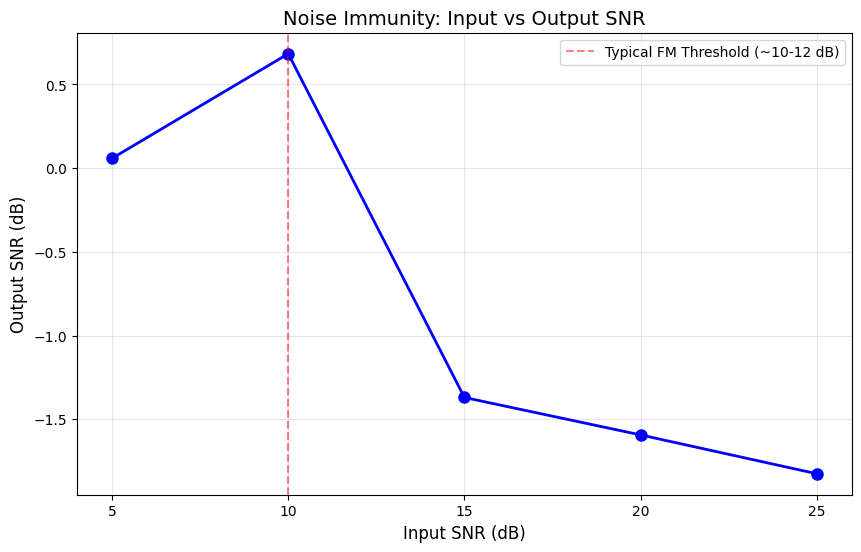

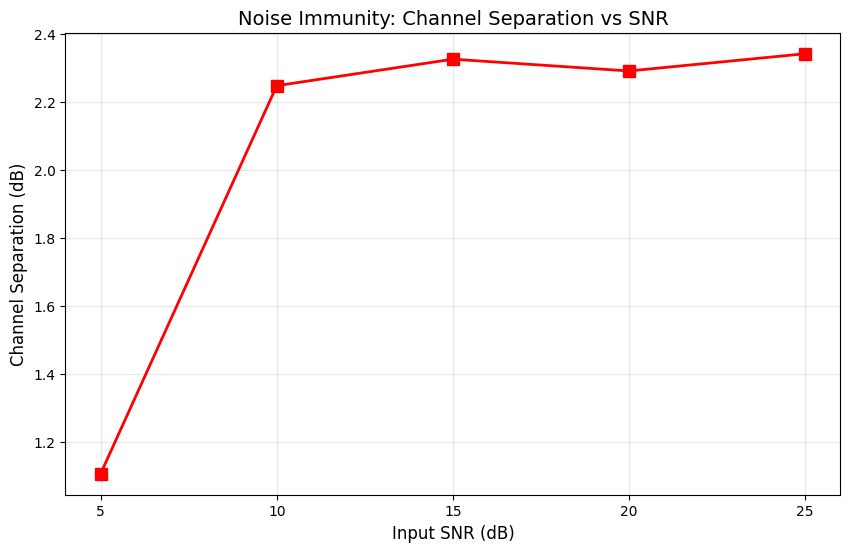

In [9]:
# PLOTTING
os.makedirs("outputs", exist_ok=True)

# 1. Input SNR vs Output SNR
plt.figure(figsize=(10, 6))
plt.plot(input_snrs, output_snrs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Input SNR (dB)', fontsize=12)
plt.ylabel('Output SNR (dB)', fontsize=12)
plt.title('Noise Immunity: Input vs Output SNR', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(input_snrs)

# Approximate Threshold identification (Linear region vs Rapid drop)
# usually around 10-12 dB input SNR for FM
plt.axvline(x=10, color='r', linestyle='--', alpha=0.5, label='Typical FM Threshold (~10-12 dB)')
plt.legend()

plt.savefig("outputs/task2_snr_curve.png", dpi=150)
plt.show()

# 2. Input SNR vs Channel Separation
plt.figure(figsize=(10, 6))
plt.plot(input_snrs, separations, 'rs-', linewidth=2, markersize=8)
plt.xlabel('Input SNR (dB)', fontsize=12)
plt.ylabel('Channel Separation (dB)', fontsize=12)
plt.title('Noise Immunity: Channel Separation vs SNR', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(input_snrs)
plt.savefig("outputs/task2_separation_curve.png", dpi=150)
plt.show()

In [10]:
# 3. Discussion
print("="*80)
print("ANALYSIS AND DISCUSSION")
print("="*80)

print("\n1. Threshold SNR Effect:")
print("   Looking at the Input vs Output SNR plot, we might observe a 'knee' or threshold.")
print("   - Above threshold: Relationship is linear (1 dB input gain -> 1 dB output gain).")
print("   - Below threshold: Output SNR drops rapidly (non-linearly).")
print("   - Cause: The 'FM Threshold Effect'. When noise vectors become comparable in")
print("     amplitude to the carrier, the phase angle can wrap around (2pi jumps),")
print("     causing impulsive 'click' noise that dominates the output.")

print("\n2. Channel Separation Performance:")
print(f"   - Max separation measured: {max(separations):.1f} dB at {input_snrs[np.argmax(separations)]} dB Input SNR.")
print("   - Separation degrades at lower SNRs because noise corrupts the pilot tone")
print("     and the L-R subcarrier recovery, causing phase errors in demodulation.")
print("     Stereo decoding relies on precise phase lock; noise jitter destroys this.")

print("\n3. THD Performance:")
print(f"   - THD at 25 dB SNR: {thds[-1]:.2f}%")
print(f"   - THD at 5 dB SNR: {thds[0]:.2f}%")
print("   - THD increases significantly at low SNR due to the non-linear nature")
print("     of fm demodulation failure (clicks) which appear as broad spectrum distortion.")

ANALYSIS AND DISCUSSION

1. Threshold SNR Effect:
   Looking at the Input vs Output SNR plot, we might observe a 'knee' or threshold.
   - Above threshold: Relationship is linear (1 dB input gain -> 1 dB output gain).
   - Below threshold: Output SNR drops rapidly (non-linearly).
   - Cause: The 'FM Threshold Effect'. When noise vectors become comparable in
     amplitude to the carrier, the phase angle can wrap around (2pi jumps),
     causing impulsive 'click' noise that dominates the output.

2. Channel Separation Performance:
   - Max separation measured: 2.3 dB at 25 dB Input SNR.
   - Separation degrades at lower SNRs because noise corrupts the pilot tone
     and the L-R subcarrier recovery, causing phase errors in demodulation.
     Stereo decoding relies on precise phase lock; noise jitter destroys this.

3. THD Performance:
   - THD at 25 dB SNR: 0.03%
   - THD at 5 dB SNR: 2.43%
   - THD increases significantly at low SNR due to the non-linear nature
     of fm demodulation 